In [105]:
import random
from math import pi
import scipy.misc
from scipy import signal
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numpy as np
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


### Shape of data

In [5]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


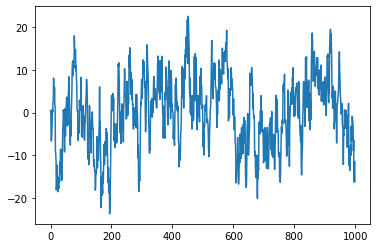

In [29]:
plt.plot(X_train_valid[9,1,:])
plt.show()

In [69]:
#data preprocess
#there are four bands might have information
num_fft=1000
X_train_valid_delta=np.zeros(X_train_valid.shape)
X_train_valid_theta=np.zeros(X_train_valid.shape)
X_train_valid_alpha=np.zeros(X_train_valid.shape)
X_train_valid_beta=np.zeros(X_train_valid.shape)


#define four filters in different passband, our sample rate is 250Hz
#Delta is 1-4Hz
#Theta is 4-7Hz
#Alpha is 8-12Hz
#Beta is 12-30Hz
filter_delta = scipy.signal.firwin(1001,[0.008,0.032], pass_zero='bandpass')
filter_theta = scipy.signal.firwin(1001,[0.032,0.056], pass_zero='bandpass')
filter_alpha = scipy.signal.firwin(1001,[0.064,0.096], pass_zero='bandpass')
filter_beta = scipy.signal.firwin(1001,[0.096,0.24], pass_zero='bandpass')

for i in range(X_train_valid.shape[1]):
    for j in range(X_train_valid.shape[0]):
        X_train_valid_delta[j,i,:]=scipy.signal.convolve(X_train_valid[j,i,:],filter_delta,mode='same')

for i in range(X_train_valid.shape[1]):
    for j in range(X_train_valid.shape[0]):
        X_train_valid_theta[j,i,:]=scipy.signal.convolve(X_train_valid[j,i,:],filter_theta,mode='same')
        
for i in range(X_train_valid.shape[1]):
    for j in range(X_train_valid.shape[0]):
        X_train_valid_alpha[j,i,:]=scipy.signal.convolve(X_train_valid[j,i,:],filter_alpha,mode='same')
        
for i in range(X_train_valid.shape[1]):
    for j in range(X_train_valid.shape[0]):
        X_train_valid_beta[j,i,:]=scipy.signal.convolve(X_train_valid[j,i,:],filter_beta,mode='same')
        


(array([5.87976269e-10, 2.93988134e-09, 5.87976269e-09, 5.87976269e-09,
       2.93988134e-09, 5.87976269e-10]), array([ 1.        , -4.90690453,  9.63193678, -9.45425987,  4.64032968,
       -0.91110204]))


trait is 1552
channel is 18


D:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
D:\anaconda\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


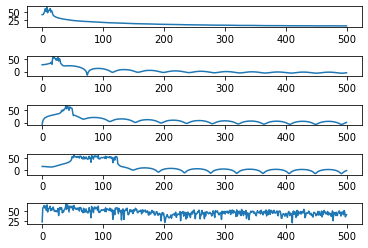

In [108]:
trait=random.randint(0,X_train_valid.shape[0])
channel=random.randint(0,X_train_valid.shape[1])
print("trait is",trait)
print("channel is",channel)

plt.subplot(911) 
y1=fft(X_train_valid_delta[trait,channel,:],num_fft)
plt.plot(20*np.log10(y1[:500]))

plt.subplot(913)
y2=fft(X_train_valid_theta[trait,channel,:],num_fft)
plt.plot(20*np.log10(y2[:500]))
plt.subplot(915)
y3=fft(X_train_valid_alpha[trait,channel,:],num_fft)
plt.plot(20*np.log10(y3[:500]))
plt.subplot(917)
y4=fft(X_train_valid_beta[trait,channel,:],num_fft)
plt.plot(20*np.log10(y4[:500]))
plt.subplot(919)
y5=fft(X_train_valid[trait,channel,:],num_fft)
plt.plot(20*np.log10(y5[:500]))

plt.show()

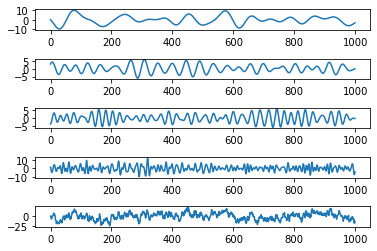

In [76]:


plt.subplot(911)        
plt.plot(X_train_valid_delta[9,1,:])
plt.subplot(913)
plt.plot(X_train_valid_theta[9,1,:])
plt.subplot(915)
plt.plot(X_train_valid_alpha[9,1,:])
plt.subplot(917)
plt.plot(X_train_valid_beta[9,1,:])
plt.subplot(919)
plt.plot(X_train_valid[9,1,:])

plt.show()

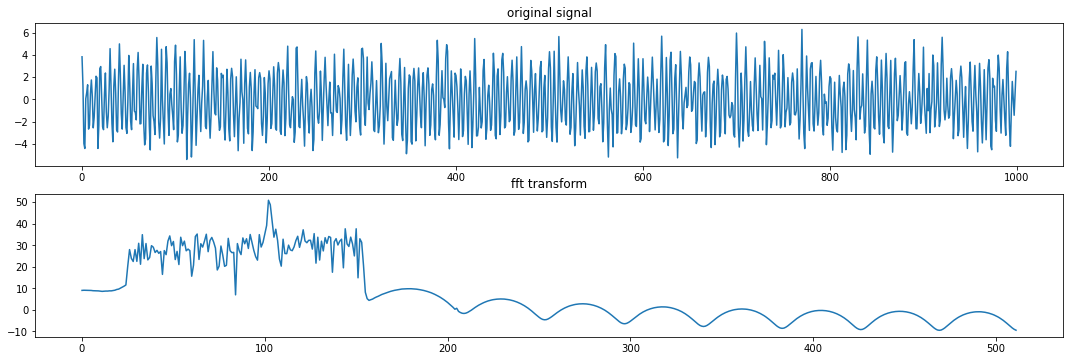